In [4]:
import os
import sys
import yaml

import torch
import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Pytorch StarDist3D
sys.path.append('..')
from pytorch_stardist.data.utils import normalize
from pytorch_stardist.models.config import Config3D
from pytorch_stardist.models.stardist3d import StarDist3D
from utils import seed_all, prepare_conf

# Need this even otherwise DDP will complain
os.environ["LOCAL_RANK"] = '0'
os.environ["RANK"] = '0'

In [5]:
def plot_mip(image):
    proj_xy = image.max(axis=0)
    proj_xz = image.max(axis=1)
    proj_yz = image.max(axis=2)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(proj_xy)
    axes[0].set_title('Max projection (XY)')
    axes[1].imshow(proj_xz)
    axes[1].set_title('Max projection (XZ)')
    axes[2].imshow(proj_yz)
    axes[2].set_title('Max projection (YZ)')
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
# Load model config
config_file = '../confs/train_convnext_unet_base-3D.yaml'

with open(config_file) as yconf:
    opt = yaml.safe_load(yconf)

Config = Config3D
StarDist = StarDist3D
conf = Config(**opt, allow_new_params=True)
opt = prepare_conf(conf)

# Model instanciation
model = StarDist(opt)
model.net.load_state_dict(torch.load('../model_checkpoints/convnext_unet_base-3D.pth'))
model.net.to(model.device)

# Probability and NMS threshold for segmentation - play around with these
model.thresholds['prob'] = 0.4
model.thresholds['nms'] = 0.2

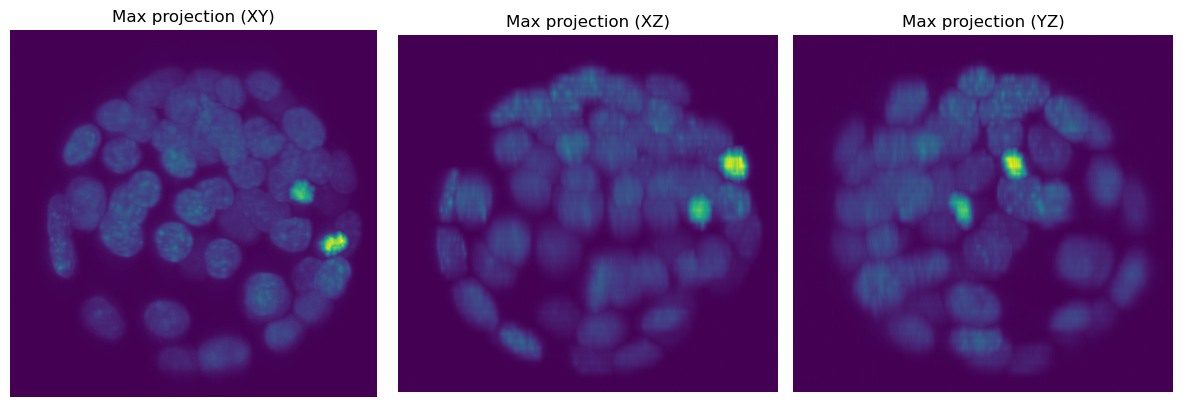

In [11]:
# Load raw anisotropic image, cropping to embryo is reccomended
image_path = 'demo_image.npy'
image = np.load(image_path)

# Anisotropy factor of z-axis
aniso_factor = 2/0.208

# Interpolate image to isotropic resolution
image = zoom(image, (aniso_factor, 1, 1), order=1) # trilinear

# Make image dimensions divisible by n (for UNET down and up):
n = 32
image = image[:image.shape[0]-image.shape[0]%n, 
              :image.shape[1]-image.shape[1]%n, 
              :image.shape[2]-image.shape[2]%n]

# Normalize image
axis_norm = (0, 1, 2)  # normalize channels independently
image = normalize(image, 1, 99.8, axis=axis_norm)
image = np.expand_dims(image, 0) # add channel dim

# Visualize max intensity projections of input image
plot_mip(image[0])

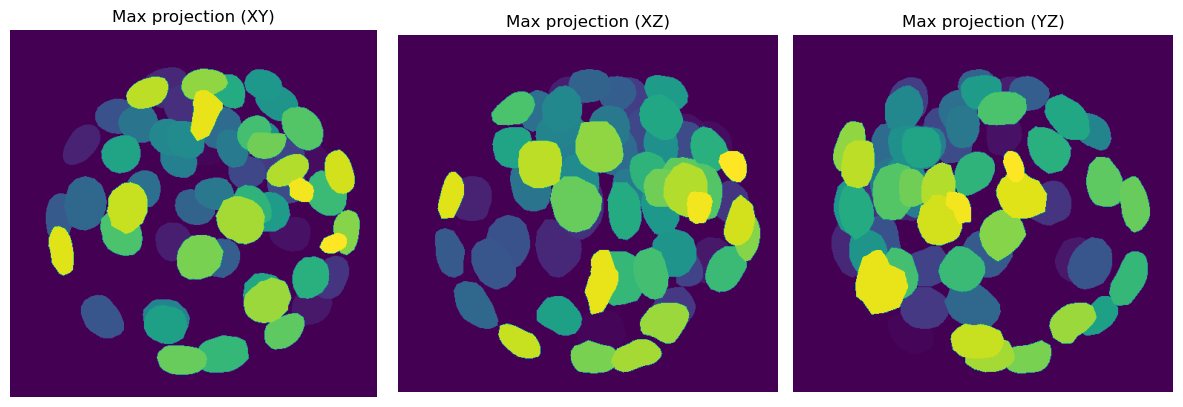

In [12]:
# Predict segmentation mask
# Needs ~10-20 GB VRAM, may take several minutes
labels, details =  model.predict_instance(image, patch_size=[256, 256, 256], context=[64, 64, 64]) 

# Visualize segmentation mask
plot_mip(labels)